In [2]:
import re
import scipy.io
from scipy import signal
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
#directory = "C:\\Users\\grazi\\Desktop\\Materiale FVAB\\SEED_IV Database\\SEED_IV Database"
#directory = "C:\\Users\\santo\\Downloads\\SEED_IV Database\\SEED_IV Database"
directory = "D:\\DATASET FVAB\\SEED_IV Database\\SEED_IV Database\\"


In [3]:
directory

'D:\\DATASET FVAB\\SEED_IV Database\\SEED_IV Database\\'

# Original code

In [4]:
path = os.path.join(directory, "eeg_raw_data", "1", "10_20151014.mat")

In [5]:
data = scipy.io.loadmat(path)

In [6]:
#Prende tutti gli header per estrarre i dati
labels = list(data.keys())
size = len(labels)

In [7]:
# Carica il dataset in un dataframe di pandas usando gli header
for i in range(3,size,1):
    df = pd.DataFrame(data[labels[i]])
    print(df.shape)
    #df.transpose()
    #df.to_csv(labels[i]+".csv")

(62, 33601)
(62, 19001)
(62, 39801)
(62, 26001)
(62, 17601)
(62, 32401)
(62, 30601)
(62, 41801)
(62, 29001)
(62, 33801)
(62, 10001)
(62, 22001)
(62, 43401)
(62, 33801)
(62, 51801)
(62, 28201)
(62, 13601)
(62, 35801)
(62, 28001)
(62, 9601)
(62, 22401)
(62, 22401)
(62, 35001)
(62, 27401)


In [48]:
channel_order = pd.read_excel(os.path.join(directory,"Channel Order.xlsx"), engine="openpyxl",header=None)

In [9]:
session1_label = [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3]
session2_label = [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1]
session3_label = [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]
targets = session1_label + session2_label + session3_label

In [10]:
directory = os.path.join(directory, 'eeg_raw_data')

# Drop channels

In [11]:
def drop_channels(df):
    df = df.set_index(channel_order[0])
    df = df.transpose()
    df = df[['FT7','FT8','T7', 'T8', 'TP7', 'TP8']]
    df = df.transpose()
    return df

In [12]:
df_6_channels = drop_channels(pd.DataFrame(data['tyc_eeg1']))

In [13]:
df_6_channels.index.names = ['Channels']

In [14]:
print(df_6_channels.shape)

(6, 33601)


# Downsampling e filtering

In [15]:
def down_sampling(data):
    sfreq = 1000
    new_sfreq = 200
    data = data.T
    
    data = signal.resample(data, int(len(data) * new_sfreq / sfreq))    
    return data

In [16]:
def band_pass_filter(data):
    sfreq = 1000
    nyquist_frequency = sfreq / 2
    lowcut = 0.3 
    highcut = 50
    order = 4
       
    b, a = signal.butter(order, [lowcut/nyquist_frequency, highcut/nyquist_frequency], btype='band')
    data = signal.filtfilt(b, a, data, padlen=0)
    return data

<AxesSubplot:>

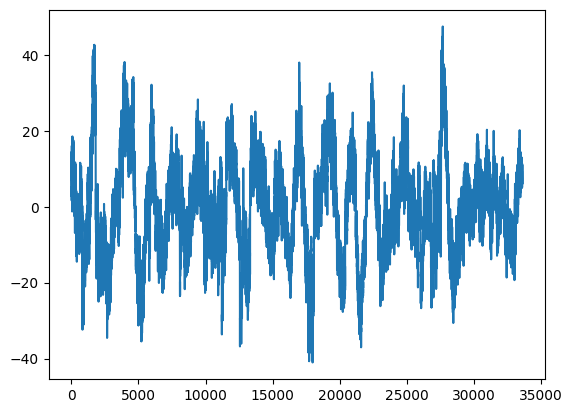

In [17]:
df_6_channels.iloc[3].plot()

In [18]:
processed_data_down = down_sampling(df_6_channels)

In [19]:
print(processed_data_down.shape)

(6720, 6)


<AxesSubplot:>

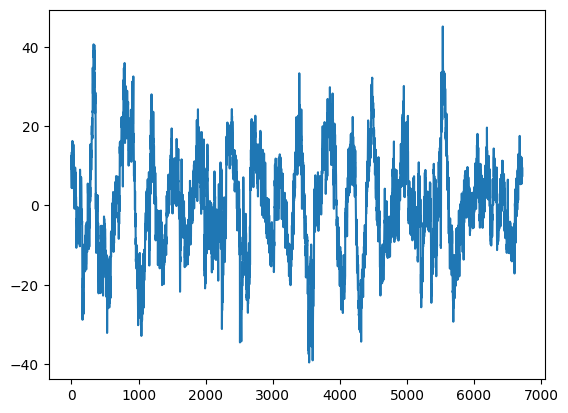

In [20]:
pd.DataFrame(processed_data_down)[3].plot()

In [21]:
processed_data_filter = band_pass_filter(processed_data_down)

In [22]:
print(processed_data_filter.shape)

(6720, 6)


<AxesSubplot:>

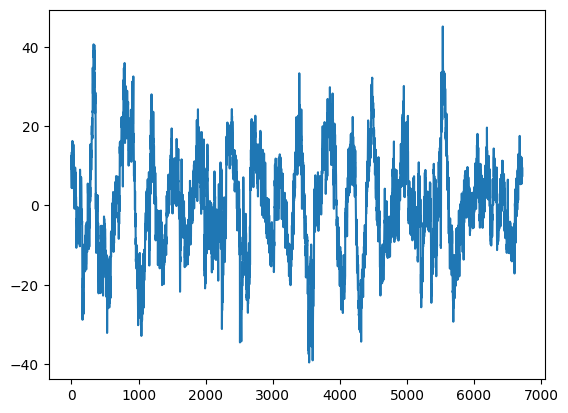

In [23]:
pd.DataFrame(processed_data_down)[3].plot()

In [24]:
filtered_dataset = pd.DataFrame(processed_data_filter).T

In [25]:
filtered_dataset['Channels'] = ['FT7','FT8','T7', 'T8', 'TP7', 'TP8']

In [26]:
filtered_dataset.set_index('Channels',inplace=True)

## Feature Extraction

### PSD

In [27]:
def psd_function(df):
    return signal.welch(df, 200 , noverlap=0, scaling="spectrum" )

In [81]:
def psd_function_nperseg(df):
    return signal.welch(df, 1000 , noverlap=0, scaling="spectrum" ,nperseg=1000)

In [29]:
f, psd = psd_function(filtered_dataset)

In [82]:
fn , psdn = psd_function_nperseg(filtered_dataset)

In [84]:
psdn.shape

(6, 501)

In [32]:
f.shape

(129,)

In [33]:
psd

array([[4.58629202e-04, 2.59448274e-03, 1.76812838e-03, 8.90338932e-04,
        7.71073861e-04, 4.38713160e-04, 2.06292724e-04, 1.85963791e-04,
        1.54299863e-04, 9.59339849e-05, 9.10601738e-05, 9.69510008e-05,
        8.92196375e-05, 7.44530637e-05, 6.25498420e-05, 4.18143750e-05,
        2.64341199e-05, 2.53899101e-05, 2.46435580e-05, 1.68642504e-05,
        2.44717278e-05, 2.64715214e-05, 1.83117699e-05, 1.81825260e-05,
        1.72619588e-05, 1.70779290e-05, 1.70015420e-05, 1.40976767e-05,
        1.16195006e-05, 1.21190278e-05, 8.52283163e-06, 8.87013450e-06,
        7.48162326e-06, 8.16390793e-06, 5.62941281e-06, 7.00792632e-06,
        9.73020740e-06, 6.85983341e-06, 4.86549382e-06, 4.40780090e-06,
        5.77111753e-06, 5.70927009e-06, 4.72801586e-06, 3.44136450e-06,
        3.54977307e-06, 4.61482178e-06, 4.21148847e-06, 3.74056367e-06,
        3.95950964e-06, 3.99572323e-06, 4.05226809e-06, 2.87947071e-06,
        1.89841966e-06, 2.01660146e-06, 2.73473403e-06, 3.312868

<AxesSubplot:>

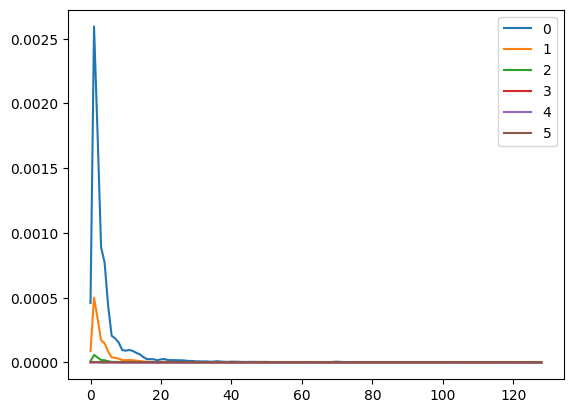

In [34]:
pd.DataFrame(psd.T).plot()

### DE

In [35]:
def de(df):
    return scipy.stats.differential_entropy(df)

In [36]:
entropy = de(psd)

In [37]:
entropyn = de(psdn)

In [38]:
entropy.shape

(129,)

<AxesSubplot:>

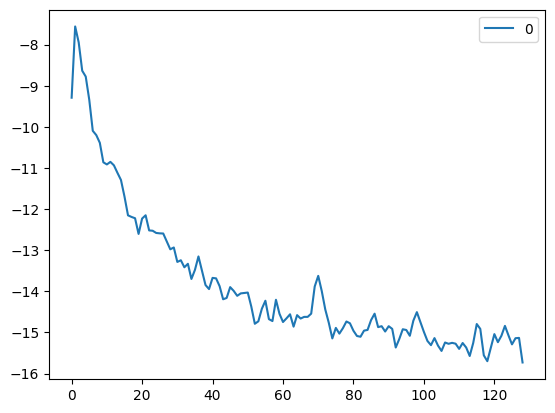

In [39]:
pd.DataFrame(entropy).plot()

### DASM

In [40]:
def dasm_function(psd):
    left_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[0,2,4]])
    right_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[1,3,5]])
    return np.abs(left_hemisphere_psd-right_hemisphere_psd)/(left_hemisphere_psd+right_hemisphere_psd)

In [41]:
dasm = dasm_function(psd)

In [42]:
dasmn = dasm_function(psdn)

In [43]:
dasm.shape

(3, 129)

<AxesSubplot:>

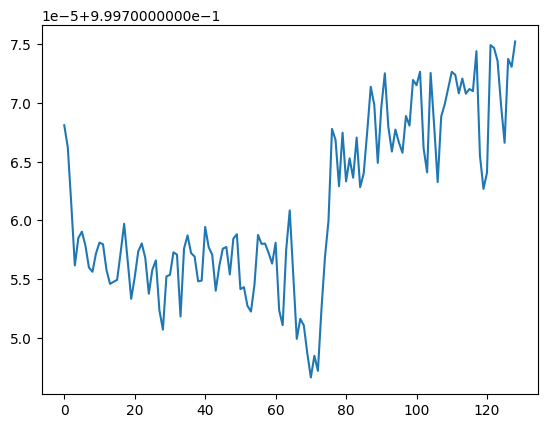

In [44]:
pd.DataFrame(dasm).iloc[2].plot()

### ASM

In [45]:
def asm_function(psd):
    left_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[0,2,4]])
    right_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[1,3,5]])
    return (np.sum(left_hemisphere_psd, axis=0) - np.sum(right_hemisphere_psd, axis=0)) / np.sum(left_hemisphere_psd + right_hemisphere_psd, axis=0)

In [46]:
asm = asm_function(psd)

In [47]:
asmn = asm_function(psdn)

In [48]:
asm.shape

(129,)

<AxesSubplot:>

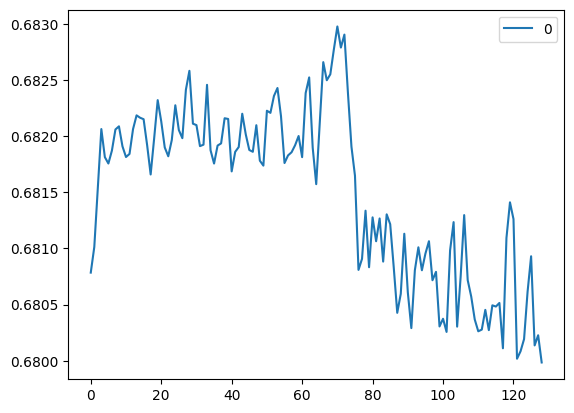

In [49]:
pd.DataFrame(asm).plot()

# Script Feature Extraction

In [50]:
def feature_extraction(dataframe_to_filter):
    #calcolo psd + de + dasm + asm
    f, psd = psd_function(dataframe_to_filter)
    entropy = de(psd)
    dasm = dasm_function(psd)
    asm = asm_function(psd)
    #print("Dims",dataframe_to_filter.shape,psd.shape,entropy.shape,dasm.shape,asm.shape)
    #combinazione risultati psd + de + dasm + asm (approccio che fa esplodere la dimensionalità del dataset)
    #print("Dim",dataframe_to_filter.shape,psd.shape)
    return np.concatenate((psd.flatten(),entropy,dasm.flatten(),asm)) 

In [66]:
def feature_extraction_nperseg(dataframe_to_filter):
    #calcolo psd + de + dasm + asm
    f, psd = psd_function_nperseg(dataframe_to_filter)
    entropy = de(psd)
    dasm = dasm_function(psd)
    asm = asm_function(psd)
    #print("Dims",psd.shape,entropy.shape,dasm.shape,asm.shape)
    #combinazione risultati psd + de + dasm + asm (approccio che fa esplodere la dimensionalità del dataset)
    #print("Dim",dataframe_to_filter.shape,psd.shape)
    return np.concatenate((psd.flatten(),entropy,dasm.flatten(),asm)),psd.flatten(),entropy,dasm.flatten(),asm

In [52]:
result = feature_extraction(filtered_dataset)

In [53]:
result,psd,entropy,dasm,asm = feature_extraction_nperseg(filtered_dataset)

In [54]:
result.shape

(5511,)

In [55]:
df = pd.DataFrame(result).T 

In [56]:
df['file'] = ['mat123432'] #placeholder temporaneo (aggiungere anche identificativo utente nella chiave)

In [57]:
df['id'] = labels[0]

In [58]:
df['label'] = targets[0]

In [59]:
df.set_index(['file','id'], inplace=True)

In [60]:
df

,,0,1,2,3,4,5,6,7,8,9,...,5502,5503,5504,5505,5506,5507,5508,5509,5510,label
file,id,,,,,,,,,,,,,,,,,,,,,
mat123432,__header__,0.000056,0.00021,0.000578,0.001068,0.001386,0.001648,0.000803,0.000437,0.000751,0.000383,...,0.680894,0.677372,0.678587,0.680154,0.679,0.679539,0.679375,0.678674,0.680591,1


# Concatenazione

In [61]:
df_global = pd.DataFrame()

In [62]:
pd.concat([df_global,df])

,,0,1,2,3,4,5,6,7,8,9,...,5502,5503,5504,5505,5506,5507,5508,5509,5510,label
file,id,,,,,,,,,,,,,,,,,,,,,
mat123432,__header__,0.000056,0.00021,0.000578,0.001068,0.001386,0.001648,0.000803,0.000437,0.000751,0.000383,...,0.680894,0.677372,0.678587,0.680154,0.679,0.679539,0.679375,0.678674,0.680591,1


In [63]:
result.shape[0]

5511

In [64]:
#print(os.getcwd())
resDF = pd.DataFrame(result).T
resDF.to_csv("10_20151014.csv")
resDF.head()

,0,1,2,3,4,5,6,7,8,9,...,5501,5502,5503,5504,5505,5506,5507,5508,5509,5510
0,0.000056,0.00021,0.000578,0.001068,0.001386,0.001648,0.000803,0.000437,0.000751,0.000383,...,0.681325,0.680894,0.677372,0.678587,0.680154,0.679,0.679539,0.679375,0.678674,0.680591


# Script

In [79]:
df_global = pd.DataFrame()
df_psd = pd.DataFrame()
df_de = pd.DataFrame()
df_asm = pd.DataFrame()
df_dasm = pd.DataFrame()
scaler = StandardScaler()
if os.path.exists(directory):
    lista_cartella_main = os.listdir(directory)
    #For che Scansiona le cartelle delle sessioni
    for file in lista_cartella_main:
        sec = os.path.join(directory, file)
        if os.path.isdir(sec):
            session = int(sec[-1])
            files1 = os.listdir(sec)
            #For che Scansiona i file .Mat nelle cartelle sessioni
            for file1 in files1:
                j = 24 * (int(session) - 1)
                if file1.endswith(".mat"):
                    file1 = os.path.join(sec, file1)
                    data = scipy.io.loadmat(file1)
                    labels = list(data.keys())
                    size = len(labels)
                    print("file1",file1)
                    for i in range(3,size,1):
                        id_user = labels[i]
                        df = pd.DataFrame(data[id_user])
                        #print("Original",df.shape)
                        drops = drop_channels(df)
                        #print("DropChannel",drops.shape)
                        downsampled = down_sampling(drops)
                        #print("DownSample",downsampled.shape)
                        filtered = band_pass_filter(downsampled)
                        print("Filtered",filtered.shape)
                        filtered_dataset = pd.DataFrame(filtered).T
                        result,psd,entropy,dasm,asm = feature_extraction_nperseg(filtered_dataset)
                        #result = feature_extraction(filtered_dataset)
                        #print("shape result",result.shape)
                        
                        psd = psd.reshape(-1,1)
                        entropy = entropy.reshape(-1,1)
                        asm = asm.reshape(-1,1)
                        dasm = dasm.reshape(-1,1)
                        
                        scaler.fit(psd)
                        psd_s = scaler.transform(psd)
                        scaler.fit(entropy)
                        entropy_s = scaler.transform(entropy)
                        scaler.fit(asm)
                        asm_s = scaler.transform(asm)
                        scaler.fit(psd)
                        dasm_s = scaler.transform(dasm)
                        
                        #Label colonne df finale
                        id_person = re.findall("\d+_", file1)
                        id_person = re.findall("\d+", id_person[0])
                        video = re.findall("\d+", labels[i])
                        target = targets[j]
                        j += 1

                        df_tmp = pd.DataFrame(result).T
                        df_tmp['id_user'] = id_person
                        df_tmp['session'] = session
                        df_tmp['video'] = video
                        df_tmp['emotion'] = target
                        
                        df_psd_tmp = pd.DataFrame(psd_s).T
                        df_de_tmp = pd.DataFrame(entropy_s).T
                        df_asm_tmp = pd.DataFrame(asm_s).T
                        df_dasm_tmp = pd.DataFrame(dasm_s).T
                        
                        df_psd_tmp['id_user'] = id_person
                        df_psd_tmp['session'] = session
                        df_psd_tmp['video'] = video
                        df_psd_tmp['emotion'] = target
                        
                        df_de_tmp['id_user'] = id_person
                        df_de_tmp['session'] = session
                        df_de_tmp['video'] = video
                        df_de_tmp['emotion'] = target
                        
                        df_asm_tmp['id_user'] = id_person
                        df_asm_tmp['session'] = session
                        df_asm_tmp['video'] = video
                        df_asm_tmp['emotion'] = target
                        
                        df_dasm_tmp['id_user'] = id_person
                        df_dasm_tmp['session'] = session
                        df_dasm_tmp['video'] = video
                        df_dasm_tmp['emotion'] = target
                        
                        
                        #print("shape tmp",df_tmp.shape)
                        df_global = pd.concat([df_global,df_tmp])
                        df_psd = pd.concat([df_psd,df_psd_tmp])
                        df_de = pd.concat([df_de,df_de_tmp])
                        df_asm = pd.concat([df_asm,df_asm_tmp])
                        df_dasm = pd.concat([df_dasm,df_dasm_tmp])
                        print("shape df",df_global.shape)
                        print("shape Altri df",df_psd.shape,df_de.shape,df_asm.shape,df_dasm.shape)
                        

file1 D:\DATASET FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\1\10_20151014.mat
Filtered (6720, 6)
shape df (1, 5515)
shape Altri df (1, 3010) (1, 505) (1, 505) (1, 1507)
Filtered (3800, 6)
shape df (2, 5515)
shape Altri df (2, 3010) (2, 505) (2, 505) (2, 1507)
Filtered (7960, 6)
shape df (3, 5515)
shape Altri df (3, 3010) (3, 505) (3, 505) (3, 1507)
Filtered (5200, 6)
shape df (4, 5515)
shape Altri df (4, 3010) (4, 505) (4, 505) (4, 1507)
Filtered (3520, 6)
shape df (5, 5515)
shape Altri df (5, 3010) (5, 505) (5, 505) (5, 1507)
Filtered (6480, 6)
shape df (6, 5515)
shape Altri df (6, 3010) (6, 505) (6, 505) (6, 1507)
Filtered (6120, 6)
shape df (7, 5515)
shape Altri df (7, 3010) (7, 505) (7, 505) (7, 1507)
Filtered (8360, 6)
shape df (8, 5515)
shape Altri df (8, 3010) (8, 505) (8, 505) (8, 1507)
Filtered (5800, 6)
shape df (9, 5515)
shape Altri df (9, 3010) (9, 505) (9, 505) (9, 1507)
Filtered (6760, 6)
shape df (10, 5515)
shape Altri df (10, 3010) (10, 505) (10, 505) (10, 1507

Filtered (8680, 6)
shape df (85, 5515)
shape Altri df (85, 3010) (85, 505) (85, 505) (85, 1507)
Filtered (6760, 6)
shape df (86, 5515)
shape Altri df (86, 3010) (86, 505) (86, 505) (86, 1507)
Filtered (10360, 6)
shape df (87, 5515)
shape Altri df (87, 3010) (87, 505) (87, 505) (87, 1507)
Filtered (5640, 6)
shape df (88, 5515)
shape Altri df (88, 3010) (88, 505) (88, 505) (88, 1507)
Filtered (2720, 6)
shape df (89, 5515)
shape Altri df (89, 3010) (89, 505) (89, 505) (89, 1507)
Filtered (7160, 6)
shape df (90, 5515)
shape Altri df (90, 3010) (90, 505) (90, 505) (90, 1507)
Filtered (5600, 6)
shape df (91, 5515)
shape Altri df (91, 3010) (91, 505) (91, 505) (91, 1507)
Filtered (1920, 6)
shape df (92, 5515)
shape Altri df (92, 3010) (92, 505) (92, 505) (92, 1507)
Filtered (4480, 6)
shape df (93, 5515)
shape Altri df (93, 3010) (93, 505) (93, 505) (93, 1507)
Filtered (4480, 6)
shape df (94, 5515)
shape Altri df (94, 3010) (94, 505) (94, 505) (94, 1507)
Filtered (7000, 6)
shape df (95, 5515)


Filtered (7000, 6)
shape df (167, 5515)
shape Altri df (167, 3010) (167, 505) (167, 505) (167, 1507)
Filtered (5480, 6)
shape df (168, 5515)
shape Altri df (168, 3010) (168, 505) (168, 505) (168, 1507)
file1 D:\DATASET FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\1\2_20150915.mat
Filtered (6720, 6)
shape df (169, 5515)
shape Altri df (169, 3010) (169, 505) (169, 505) (169, 1507)
Filtered (3800, 6)
shape df (170, 5515)
shape Altri df (170, 3010) (170, 505) (170, 505) (170, 1507)
Filtered (7960, 6)
shape df (171, 5515)
shape Altri df (171, 3010) (171, 505) (171, 505) (171, 1507)
Filtered (5200, 6)
shape df (172, 5515)
shape Altri df (172, 3010) (172, 505) (172, 505) (172, 1507)
Filtered (3520, 6)
shape df (173, 5515)
shape Altri df (173, 3010) (173, 505) (173, 505) (173, 1507)
Filtered (6480, 6)
shape df (174, 5515)
shape Altri df (174, 3010) (174, 505) (174, 505) (174, 1507)
Filtered (6120, 6)
shape df (175, 5515)
shape Altri df (175, 3010) (175, 505) (175, 505) (175, 1507)
Filte

Filtered (6120, 6)
shape df (247, 5515)
shape Altri df (247, 3010) (247, 505) (247, 505) (247, 1507)
Filtered (8360, 6)
shape df (248, 5515)
shape Altri df (248, 3010) (248, 505) (248, 505) (248, 1507)
Filtered (5800, 6)
shape df (249, 5515)
shape Altri df (249, 3010) (249, 505) (249, 505) (249, 1507)
Filtered (6760, 6)
shape df (250, 5515)
shape Altri df (250, 3010) (250, 505) (250, 505) (250, 1507)
Filtered (2000, 6)
shape df (251, 5515)
shape Altri df (251, 3010) (251, 505) (251, 505) (251, 1507)
Filtered (4400, 6)
shape df (252, 5515)
shape Altri df (252, 3010) (252, 505) (252, 505) (252, 1507)
Filtered (8680, 6)
shape df (253, 5515)
shape Altri df (253, 3010) (253, 505) (253, 505) (253, 1507)
Filtered (6760, 6)
shape df (254, 5515)
shape Altri df (254, 3010) (254, 505) (254, 505) (254, 1507)
Filtered (10360, 6)
shape df (255, 5515)
shape Altri df (255, 3010) (255, 505) (255, 505) (255, 1507)
Filtered (5640, 6)
shape df (256, 5515)
shape Altri df (256, 3010) (256, 505) (256, 505) (

shape df (327, 5515)
shape Altri df (327, 3010) (327, 505) (327, 505) (327, 1507)
Filtered (5640, 6)
shape df (328, 5515)
shape Altri df (328, 3010) (328, 505) (328, 505) (328, 1507)
Filtered (2720, 6)
shape df (329, 5515)
shape Altri df (329, 3010) (329, 505) (329, 505) (329, 1507)
Filtered (7160, 6)
shape df (330, 5515)
shape Altri df (330, 3010) (330, 505) (330, 505) (330, 1507)
Filtered (5600, 6)
shape df (331, 5515)
shape Altri df (331, 3010) (331, 505) (331, 505) (331, 1507)
Filtered (1920, 6)
shape df (332, 5515)
shape Altri df (332, 3010) (332, 505) (332, 505) (332, 1507)
Filtered (4480, 6)
shape df (333, 5515)
shape Altri df (333, 3010) (333, 505) (333, 505) (333, 1507)
Filtered (4480, 6)
shape df (334, 5515)
shape Altri df (334, 3010) (334, 505) (334, 505) (334, 1507)
Filtered (7000, 6)
shape df (335, 5515)
shape Altri df (335, 3010) (335, 505) (335, 505) (335, 1507)
Filtered (5480, 6)
shape df (336, 5515)
shape Altri df (336, 3010) (336, 505) (336, 505) (336, 1507)
file1 D:\

Filtered (3040, 6)
shape df (408, 5515)
shape Altri df (408, 3010) (408, 505) (408, 505) (408, 1507)
file1 D:\DATASET FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\2\12_20150804.mat
Filtered (8840, 6)
shape df (409, 5515)
shape Altri df (409, 3010) (409, 505) (409, 505) (409, 1507)
Filtered (4040, 6)
shape df (410, 5515)
shape Altri df (410, 3010) (410, 505) (410, 505) (410, 1507)
Filtered (5560, 6)
shape df (411, 5515)
shape Altri df (411, 3010) (411, 505) (411, 505) (411, 1507)
Filtered (5840, 6)
shape df (412, 5515)
shape Altri df (412, 3010) (412, 505) (412, 505) (412, 1507)
Filtered (8560, 6)
shape df (413, 5515)
shape Altri df (413, 3010) (413, 505) (413, 505) (413, 1507)
Filtered (4440, 6)
shape df (414, 5515)
shape Altri df (414, 3010) (414, 505) (414, 505) (414, 1507)
Filtered (5560, 6)
shape df (415, 5515)
shape Altri df (415, 3010) (415, 505) (415, 505) (415, 1507)
Filtered (7360, 6)
shape df (416, 5515)
shape Altri df (416, 3010) (416, 505) (416, 505) (416, 1507)
Filt

shape df (488, 5515)
shape Altri df (488, 3010) (488, 505) (488, 505) (488, 1507)
Filtered (5520, 6)
shape df (489, 5515)
shape Altri df (489, 3010) (489, 505) (489, 505) (489, 1507)
Filtered (3320, 6)
shape df (490, 5515)
shape Altri df (490, 3010) (490, 505) (490, 505) (490, 1507)
Filtered (9600, 6)
shape df (491, 5515)
shape Altri df (491, 3010) (491, 505) (491, 505) (491, 1507)
Filtered (2000, 6)
shape df (492, 5515)
shape Altri df (492, 3010) (492, 505) (492, 505) (492, 1507)
Filtered (5840, 6)
shape df (493, 5515)
shape Altri df (493, 3010) (493, 505) (493, 505) (493, 1507)
Filtered (4320, 6)
shape df (494, 5515)
shape Altri df (494, 3010) (494, 505) (494, 505) (494, 1507)
Filtered (7040, 6)
shape df (495, 5515)
shape Altri df (495, 3010) (495, 505) (495, 505) (495, 1507)
Filtered (2440, 6)
shape df (496, 5515)
shape Altri df (496, 3010) (496, 505) (496, 505) (496, 1507)
Filtered (7480, 6)
shape df (497, 5515)
shape Altri df (497, 3010) (497, 505) (497, 505) (497, 1507)
Filtered 

Filtered (7480, 6)
shape df (569, 5515)
shape Altri df (569, 3010) (569, 505) (569, 505) (569, 1507)
Filtered (7840, 6)
shape df (570, 5515)
shape Altri df (570, 3010) (570, 505) (570, 505) (570, 1507)
Filtered (7280, 6)
shape df (571, 5515)
shape Altri df (571, 3010) (571, 505) (571, 505) (571, 1507)
Filtered (1720, 6)
shape df (572, 5515)
shape Altri df (572, 3010) (572, 505) (572, 505) (572, 1507)
Filtered (5960, 6)
shape df (573, 5515)
shape Altri df (573, 3010) (573, 505) (573, 505) (573, 1507)
Filtered (7040, 6)
shape df (574, 5515)
shape Altri df (574, 3010) (574, 505) (574, 505) (574, 1507)
Filtered (3920, 6)
shape df (575, 5515)
shape Altri df (575, 3010) (575, 505) (575, 505) (575, 1507)
Filtered (3040, 6)
shape df (576, 5515)
shape Altri df (576, 3010) (576, 505) (576, 505) (576, 1507)
file1 D:\DATASET FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\2\4_20151118.mat
Filtered (8840, 6)
shape df (577, 5515)
shape Altri df (577, 3010) (577, 505) (577, 505) (577, 1507)
Filte

file1 D:\DATASET FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\2\7_20150717.mat
Filtered (8840, 6)
shape df (649, 5515)
shape Altri df (649, 3010) (649, 505) (649, 505) (649, 1507)
Filtered (4040, 6)
shape df (650, 5515)
shape Altri df (650, 3010) (650, 505) (650, 505) (650, 1507)
Filtered (5560, 6)
shape df (651, 5515)
shape Altri df (651, 3010) (651, 505) (651, 505) (651, 1507)
Filtered (5840, 6)
shape df (652, 5515)
shape Altri df (652, 3010) (652, 505) (652, 505) (652, 1507)
Filtered (8560, 6)
shape df (653, 5515)
shape Altri df (653, 3010) (653, 505) (653, 505) (653, 1507)
Filtered (4440, 6)
shape df (654, 5515)
shape Altri df (654, 3010) (654, 505) (654, 505) (654, 1507)
Filtered (5560, 6)
shape df (655, 5515)
shape Altri df (655, 3010) (655, 505) (655, 505) (655, 1507)
Filtered (7360, 6)
shape df (656, 5515)
shape Altri df (656, 3010) (656, 505) (656, 505) (656, 1507)
Filtered (5520, 6)
shape df (657, 5515)
shape Altri df (657, 3010) (657, 505) (657, 505) (657, 1507)
Filte

Filtered (10320, 6)
shape df (727, 5515)
shape Altri df (727, 3010) (727, 505) (727, 505) (727, 1507)
Filtered (3720, 6)
shape df (728, 5515)
shape Altri df (728, 3010) (728, 505) (728, 505) (728, 1507)
Filtered (4160, 6)
shape df (729, 5515)
shape Altri df (729, 3010) (729, 505) (729, 505) (729, 1507)
Filtered (2560, 6)
shape df (730, 5515)
shape Altri df (730, 3010) (730, 505) (730, 505) (730, 1507)
Filtered (8280, 6)
shape df (731, 5515)
shape Altri df (731, 3010) (731, 505) (731, 505) (731, 1507)
Filtered (6600, 6)
shape df (732, 5515)
shape Altri df (732, 3010) (732, 505) (732, 505) (732, 1507)
Filtered (6280, 6)
shape df (733, 5515)
shape Altri df (733, 3010) (733, 505) (733, 505) (733, 1507)
Filtered (3080, 6)
shape df (734, 5515)
shape Altri df (734, 3010) (734, 505) (734, 505) (734, 1507)
Filtered (4600, 6)
shape df (735, 5515)
shape Altri df (735, 3010) (735, 505) (735, 505) (735, 1507)
Filtered (7080, 6)
shape df (736, 5515)
shape Altri df (736, 3010) (736, 505) (736, 505) (

shape df (807, 5515)
shape Altri df (807, 3010) (807, 505) (807, 505) (807, 1507)
Filtered (7080, 6)
shape df (808, 5515)
shape Altri df (808, 3010) (808, 505) (808, 505) (808, 1507)
Filtered (2280, 6)
shape df (809, 5515)
shape Altri df (809, 3010) (809, 505) (809, 505) (809, 1507)
Filtered (2800, 6)
shape df (810, 5515)
shape Altri df (810, 3010) (810, 505) (810, 505) (810, 1507)
Filtered (7320, 6)
shape df (811, 5515)
shape Altri df (811, 3010) (811, 505) (811, 505) (811, 1507)
Filtered (3560, 6)
shape df (812, 5515)
shape Altri df (812, 3010) (812, 505) (812, 505) (812, 1507)
Filtered (6360, 6)
shape df (813, 5515)
shape Altri df (813, 3010) (813, 505) (813, 505) (813, 1507)
Filtered (6200, 6)
shape df (814, 5515)
shape Altri df (814, 3010) (814, 505) (814, 505) (814, 1507)
Filtered (6600, 6)
shape df (815, 5515)
shape Altri df (815, 3010) (815, 505) (815, 505) (815, 1507)
Filtered (6240, 6)
shape df (816, 5515)
shape Altri df (816, 3010) (816, 505) (816, 505) (816, 1507)
file1 D:\

shape df (886, 5515)
shape Altri df (886, 3010) (886, 505) (886, 505) (886, 1507)
Filtered (6600, 6)
shape df (887, 5515)
shape Altri df (887, 3010) (887, 505) (887, 505) (887, 1507)
Filtered (6240, 6)
shape df (888, 5515)
shape Altri df (888, 3010) (888, 505) (888, 505) (888, 1507)
file1 D:\DATASET FVAB\SEED_IV Database\SEED_IV Database\eeg_raw_data\3\2_20151012.mat
Filtered (6800, 6)
shape df (889, 5515)
shape Altri df (889, 3010) (889, 505) (889, 505) (889, 1507)
Filtered (5200, 6)
shape df (890, 5515)
shape Altri df (890, 3010) (890, 505) (890, 505) (890, 1507)
Filtered (3680, 6)
shape df (891, 5515)
shape Altri df (891, 3010) (891, 505) (891, 505) (891, 1507)
Filtered (7280, 6)
shape df (892, 5515)
shape Altri df (892, 3010) (892, 505) (892, 505) (892, 1507)
Filtered (7720, 6)
shape df (893, 5515)
shape Altri df (893, 3010) (893, 505) (893, 505) (893, 1507)
Filtered (4240, 6)
shape df (894, 5515)
shape Altri df (894, 3010) (894, 505) (894, 505) (894, 1507)
Filtered (10320, 6)
shap

Filtered (7720, 6)
shape df (965, 5515)
shape Altri df (965, 3010) (965, 505) (965, 505) (965, 1507)
Filtered (4240, 6)
shape df (966, 5515)
shape Altri df (966, 3010) (966, 505) (966, 505) (966, 1507)
Filtered (10320, 6)
shape df (967, 5515)
shape Altri df (967, 3010) (967, 505) (967, 505) (967, 1507)
Filtered (3720, 6)
shape df (968, 5515)
shape Altri df (968, 3010) (968, 505) (968, 505) (968, 1507)
Filtered (4160, 6)
shape df (969, 5515)
shape Altri df (969, 3010) (969, 505) (969, 505) (969, 1507)
Filtered (2560, 6)
shape df (970, 5515)
shape Altri df (970, 3010) (970, 505) (970, 505) (970, 1507)
Filtered (8280, 6)
shape df (971, 5515)
shape Altri df (971, 3010) (971, 505) (971, 505) (971, 1507)
Filtered (6600, 6)
shape df (972, 5515)
shape Altri df (972, 3010) (972, 505) (972, 505) (972, 1507)
Filtered (6280, 6)
shape df (973, 5515)
shape Altri df (973, 3010) (973, 505) (973, 505) (973, 1507)
Filtered (3080, 6)
shape df (974, 5515)
shape Altri df (974, 3010) (974, 505) (974, 505) (

Filtered (8280, 6)
shape df (1043, 5515)
shape Altri df (1043, 3010) (1043, 505) (1043, 505) (1043, 1507)
Filtered (6600, 6)
shape df (1044, 5515)
shape Altri df (1044, 3010) (1044, 505) (1044, 505) (1044, 1507)
Filtered (6280, 6)
shape df (1045, 5515)
shape Altri df (1045, 3010) (1045, 505) (1045, 505) (1045, 1507)
Filtered (3080, 6)
shape df (1046, 5515)
shape Altri df (1046, 3010) (1046, 505) (1046, 505) (1046, 1507)
Filtered (4600, 6)
shape df (1047, 5515)
shape Altri df (1047, 3010) (1047, 505) (1047, 505) (1047, 1507)
Filtered (7080, 6)
shape df (1048, 5515)
shape Altri df (1048, 3010) (1048, 505) (1048, 505) (1048, 1507)
Filtered (2280, 6)
shape df (1049, 5515)
shape Altri df (1049, 3010) (1049, 505) (1049, 505) (1049, 1507)
Filtered (2800, 6)
shape df (1050, 5515)
shape Altri df (1050, 3010) (1050, 505) (1050, 505) (1050, 1507)
Filtered (7320, 6)
shape df (1051, 5515)
shape Altri df (1051, 3010) (1051, 505) (1051, 505) (1051, 1507)
Filtered (3560, 6)
shape df (1052, 5515)
shape

In [ ]:
df_global.head()

In [ ]:
df_global.tail()

In [ ]:
df_global.describe()

In [ ]:
df_global.columns

In [80]:
df_global.to_csv('dataset_eeg_nseg.csv')
df_psd.to_csv('dataset_eeg_psds.csv')
df_de.to_csv('dataset_eeg_des.csv')
df_asm.to_csv('dataset_eeg_asms.csv')
df_dasm.to_csv('dataset_eeg_dasms.csv')

# FEATURE EXTRACTED SEEDIV

In [4]:
path = os.path.join(directory, "eeg_feature_smooth", "1", "10_20151014.mat")

data = scipy.io.loadmat(path)



In [7]:
keys = list(data.keys())
print(keys)


['__header__', '__version__', '__globals__', 'de_movingAve1', 'de_LDS1', 'psd_movingAve1', 'psd_LDS1', 'de_movingAve2', 'de_LDS2', 'psd_movingAve2', 'psd_LDS2', 'de_movingAve3', 'de_LDS3', 'psd_movingAve3', 'psd_LDS3', 'de_movingAve4', 'de_LDS4', 'psd_movingAve4', 'psd_LDS4', 'de_movingAve5', 'de_LDS5', 'psd_movingAve5', 'psd_LDS5', 'de_movingAve6', 'de_LDS6', 'psd_movingAve6', 'psd_LDS6', 'de_movingAve7', 'de_LDS7', 'psd_movingAve7', 'psd_LDS7', 'de_movingAve8', 'de_LDS8', 'psd_movingAve8', 'psd_LDS8', 'de_movingAve9', 'de_LDS9', 'psd_movingAve9', 'psd_LDS9', 'de_movingAve10', 'de_LDS10', 'psd_movingAve10', 'psd_LDS10', 'de_movingAve11', 'de_LDS11', 'psd_movingAve11', 'psd_LDS11', 'de_movingAve12', 'de_LDS12', 'psd_movingAve12', 'psd_LDS12', 'de_movingAve13', 'de_LDS13', 'psd_movingAve13', 'psd_LDS13', 'de_movingAve14', 'de_LDS14', 'psd_movingAve14', 'psd_LDS14', 'de_movingAve15', 'de_LDS15', 'psd_movingAve15', 'psd_LDS15', 'de_movingAve16', 'de_LDS16', 'psd_movingAve16', 'psd_LDS16',

In [11]:
de_LDS_key = []
for key in keys:
    if "de_LDS" in key:
        de_LDS_key.append(key)

In [12]:
de_LDS_key

['de_LDS1',
 'de_LDS2',
 'de_LDS3',
 'de_LDS4',
 'de_LDS5',
 'de_LDS6',
 'de_LDS7',
 'de_LDS8',
 'de_LDS9',
 'de_LDS10',
 'de_LDS11',
 'de_LDS12',
 'de_LDS13',
 'de_LDS14',
 'de_LDS15',
 'de_LDS16',
 'de_LDS17',
 'de_LDS18',
 'de_LDS19',
 'de_LDS20',
 'de_LDS21',
 'de_LDS22',
 'de_LDS23',
 'de_LDS24']

In [15]:
data[key].shape

(62, 42, 5)

In [18]:
deee = data[keys[1]]

In [49]:
channel_order

,0
0,FP1
1,FPZ
2,FP2
3,AF3
4,AF4
...,...
57,CB1
58,O1
59,OZ
60,O2


In [60]:
numero_riga = np.array(channel_order[channel_order[0].isin(['FT7','FT8','T7', 'T8', 'TP7', 'TP8'])].index)

In [61]:
numero_riga

array([14, 22, 23, 31, 32, 40], dtype=int64)

In [72]:
pd_de = pd.DataFrame()
for key in de_LDS_key:
    tmp_d = data[key]
    tmp_d
    
    
#    print(tmp_d[numero_riga][:][:].shape)
#    print(tmp_d.shape[1])
#    for i in range(1,tmp_d.shape[1]):
#        tmp = pd.DataFrame(tmp_d[numero_riga][i])
#        print(tmp.shape)
#    
#    
#    for x in tmp_d[numero_riga][:][:]:
#        tmp = pd.DataFrame(x)
#        
#        pd_de = pd.concat([pd_de,tmp])
    

(6, 42, 5)
42
(42, 5)
(42, 5)
(42, 5)
(42, 5)
(42, 5)


IndexError: index 6 is out of bounds for axis 0 with size 6

In [66]:
pd_de

,0,1,2,3,4
0,25.622467,22.612988,21.225053,19.946429,19.266408
1,25.622495,22.613687,21.224919,19.946356,19.266613
2,25.622713,22.614527,21.224857,19.945357,19.265513
3,25.622666,22.614596,21.225026,19.944099,19.263487
4,25.622680,22.614679,21.225726,19.942574,19.260753
...,...,...,...,...,...
29,22.879413,20.676051,19.890732,18.555267,18.305115
30,22.877478,20.676385,19.890768,18.555240,18.303546
31,22.875913,20.676128,19.890252,18.555643,18.302888
32,22.874595,20.675826,19.889915,18.555949,18.303320
